In [1]:
# add src to the sys path of this notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent / "src"))

from data.load_data import load_data, list_logs, load_labels
from data.preprocess_data import preprocess_logs_old, get_label_timeseries, downsample, filter
from models.helpers import create_model_params
from models.buckling_model import BucklingModel
from models.double_slope_model import DoubleSlopeModel
import data.paths as config
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
log_names.reset_index(drop=True, inplace=True)
logs = load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Loaded 208 logs from paper experiments.


In [4]:
log_names.head()

,path,path_markers,datetime,clot_index,direction,stiffness,pressure,clot_presence
0,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:38:36,1,Forward,NaN,NaN,With
1,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:40:03,1,Backward,NaN,NaN,With
2,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:53:54,2,Forward,NaN,NaN,With
3,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:55:28,2,Backward,NaN,NaN,With
4,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 16:04:04,3,Forward,NaN,NaN,With


In [5]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 105 logs with direction Backwards and 105 logs with direction Forwards.


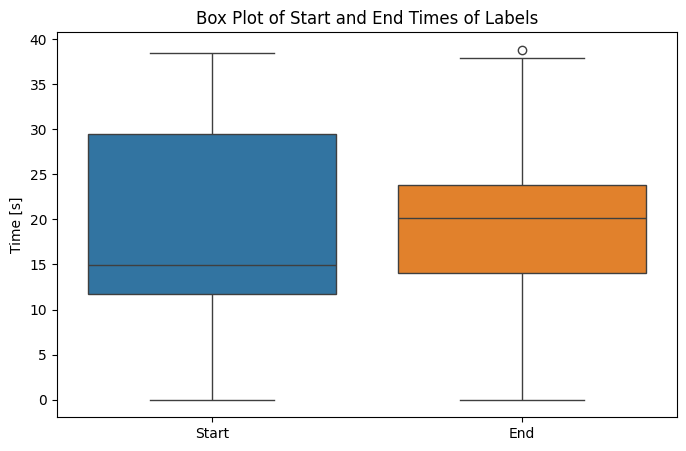

In [6]:
labels = load_labels(log_names)
labels[0].head()
# create data frame with all labels
all_labels = pd.DataFrame()
for i, label in enumerate(labels):
    label['log_index'] = i
    all_labels = pd.concat([all_labels, label], ignore_index=True)
# plot box plot of Start and End columns
plt.figure(figsize=(8, 5))
sns.boxplot(data=all_labels[['Start', 'End']])
plt.title('Box Plot of Start and End Times of Labels')
plt.ylabel('Time [s]')
plt.show()

In [7]:
# If I define accuray as being +- 1.5s from the actual start and end times, how accurate am I if I alwax predict mean start and end times?
mean_start = all_labels['Start'].mean()
mean_end = all_labels['End'].mean()
tolerance = 1.5
accurate_starts = sum((all_labels['Start'] >= mean_start - tolerance) & (all_labels['Start'] <= mean_start + tolerance))
accurate_ends = sum((all_labels['End'] >= mean_end - tolerance) & (all_labels['End'] <= mean_end + tolerance))
total_labels = len(all_labels)
print(f"Accuracy for Start times: {accurate_starts}/{total_labels} ({accurate_starts/total_labels*100:.2f}%)")
print(f"Accuracy for End times: {accurate_ends}/{total_labels} ({accurate_ends/total_labels*100:.2f}%)")

Accuracy for Start times: 13/210 (6.19%)
Accuracy for End times: 56/210 (26.67%)


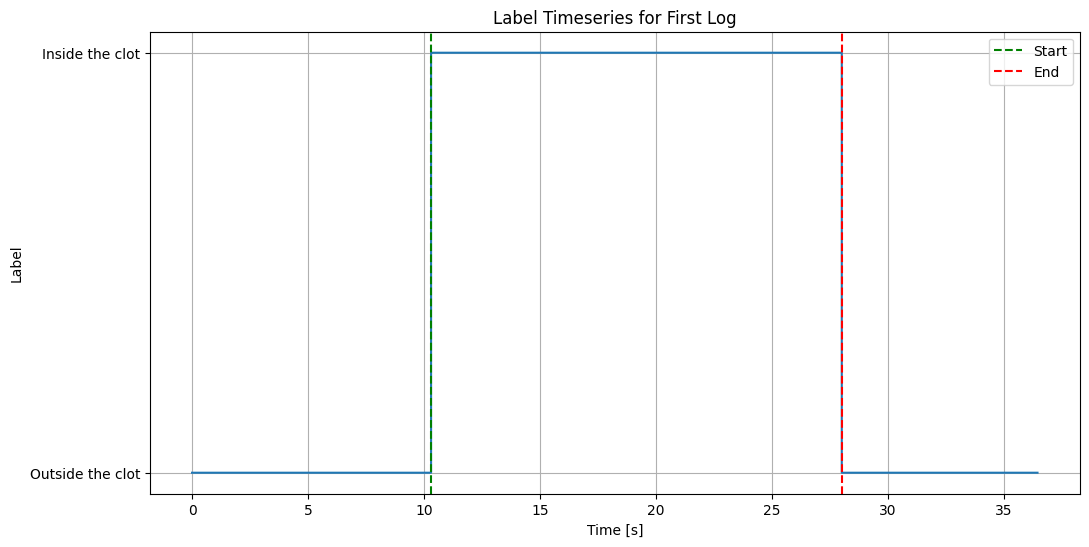

In [8]:
label_timeseries = get_label_timeseries(labels, logs)
# plot the first label timeseries
plt.figure(figsize=(12, 6))
plt.plot(label_timeseries[0]['timestamps'], label_timeseries[0]['in_clot'], drawstyle='steps-post')
# add vertical line at start and end labels 
plt.axvline(x=labels[0]['Start'].values[0], color='g', linestyle='--', label='Start')
plt.axvline(x=labels[0]['End'].values[0], color='r', linestyle='--', label='End')
plt.xlabel('Time [s]')
plt.ylabel('Label')
# make y ticks 0 and 1
plt.yticks([0, 1], ['Outside the clot', 'Inside the clot'])
plt.title('Label Timeseries for First Log')
plt.grid()
plt.legend()
plt.show()

In [9]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs_old(logs_fit, data_fit, data_fit_plot)

210it [00:01, 138.55it/s]

Preprocessing time: 1.548 s


# Visualize the Data

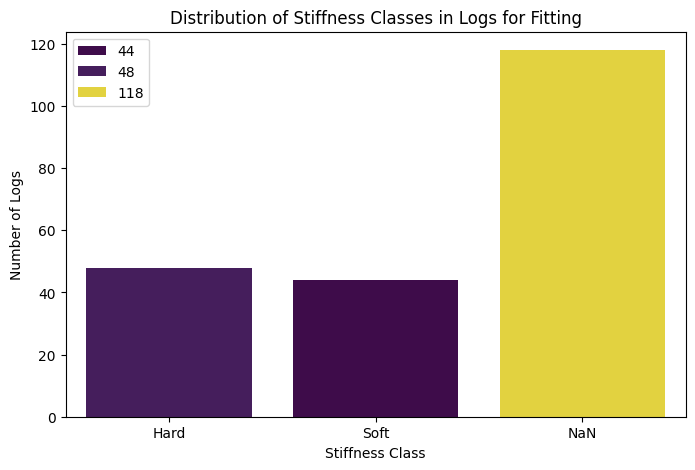

In [10]:
# visualize the distribution of stiffness classes in logs_fit
stiffness_counts = logs_fit['stiffness'].value_counts(dropna=False).sort_index()
# Replace NaN index with a readable label
labelz = ['NaN' if pd.isna(x) else x for x in stiffness_counts.index]
plt.figure(figsize=(8, 5))
sns.barplot(x=labelz, y=stiffness_counts.values, hue=stiffness_counts.values, palette="viridis", dodge=False)
plt.xlabel('Stiffness Class')
plt.ylabel('Number of Logs')
plt.title('Distribution of Stiffness Classes in Logs for Fitting')
plt.show()


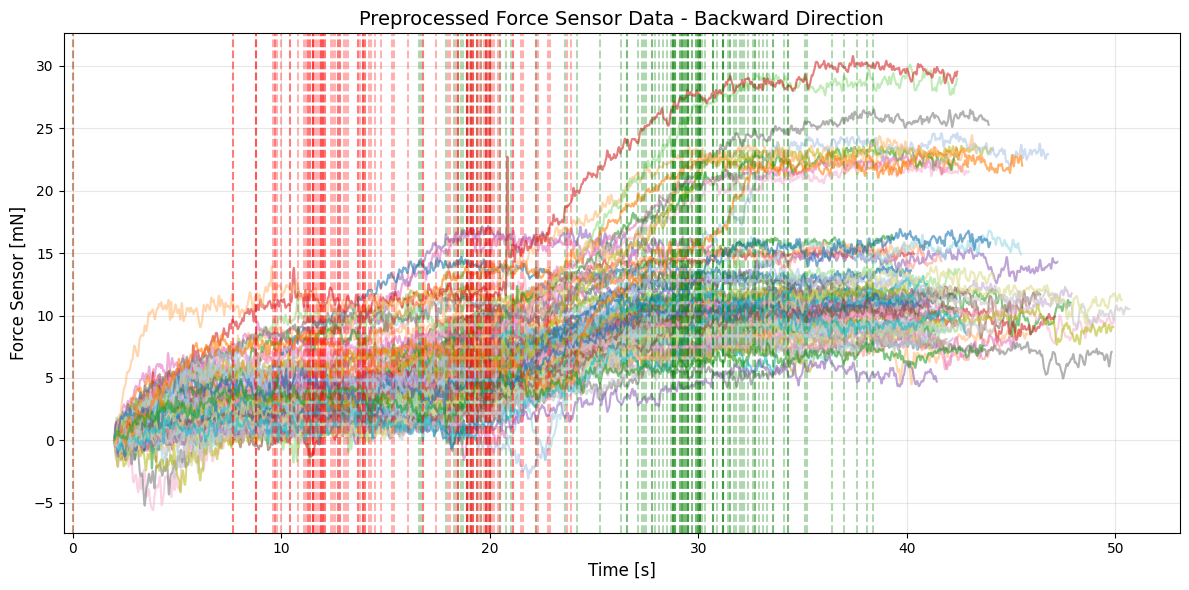

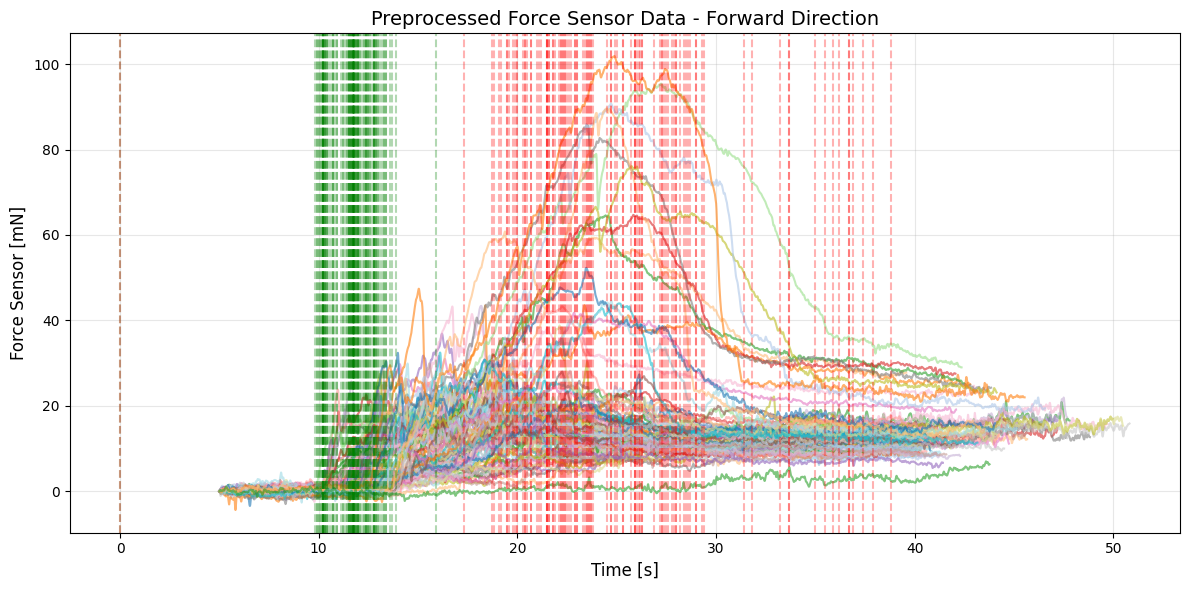

In [11]:


# Combine all curves into a single DataFrame for easier plotting
plot_data = []
for i, df in enumerate(data_fit_plot):
    df_plot = df.copy()
    df_plot['log_index'] = i
    df_plot['direction'] = logs_fit.loc[i, 'direction']
    df_plot['stiffness'] = logs_fit.loc[i, 'stiffness']
    plot_data.append(df_plot)
plot_df = pd.concat(plot_data, ignore_index=True)


for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='log_index',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        legend=False            # Avoid huge legends
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    # plot on the x axis all the start and end times of the labels as vertical lines
    dir_labels = logs_fit[logs_fit['direction'] == direction].index
    for idx in dir_labels:
        start_time = labels[idx]['Start'].values[0]
        end_time = labels[idx]['End'].values[0]
        plt.axvline(x=start_time, color='g', linestyle='--', alpha=0.3)
        plt.axvline(x=end_time, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

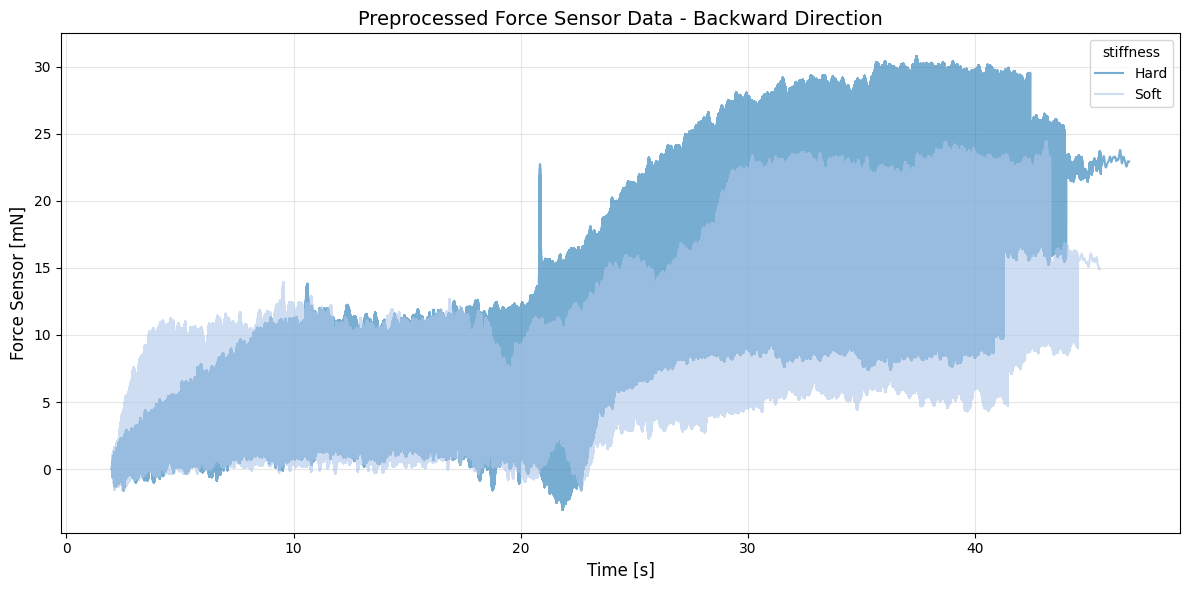

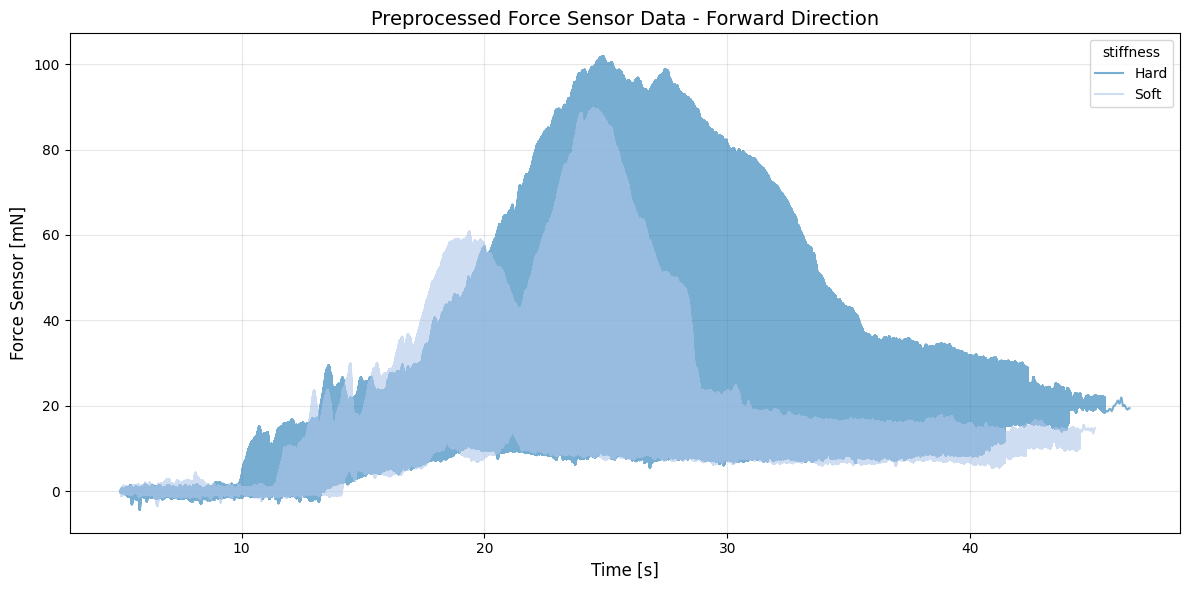

In [12]:
for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='stiffness',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        estimator=None
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Models

# Downsampling

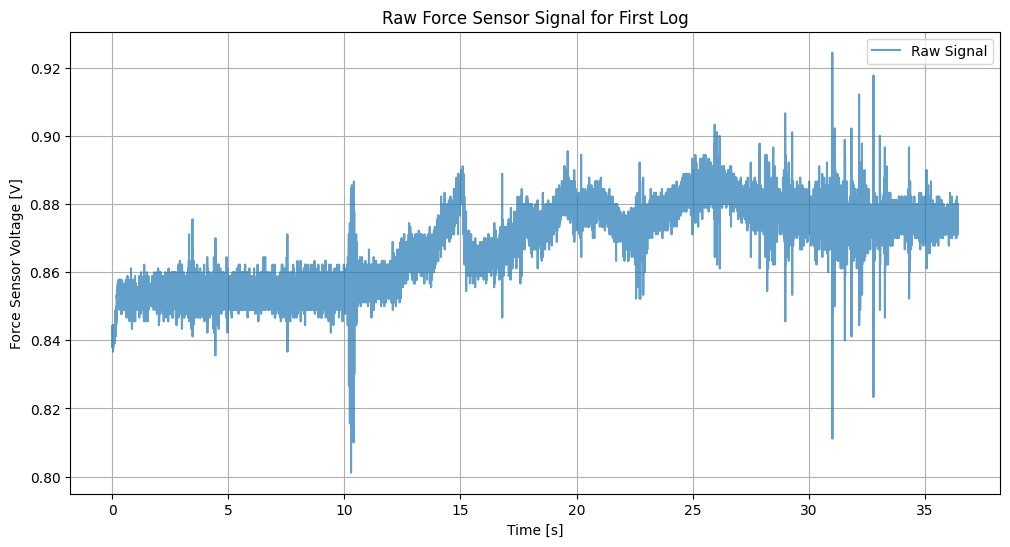

In [13]:
# plot raw signal of first log
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], logs[0]['force_sensor_v'], label='Raw Signal', alpha=0.7)
plt.title('Raw Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

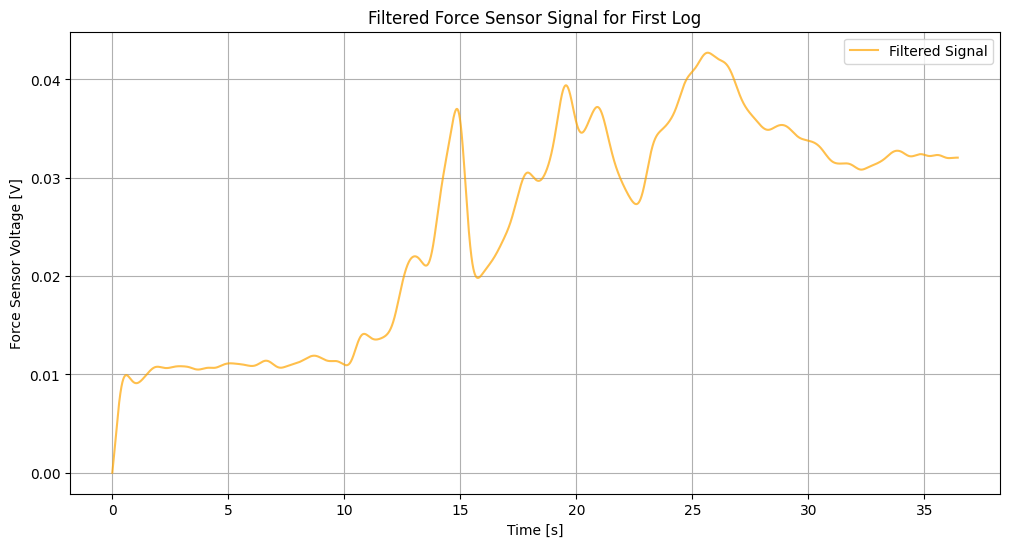

In [14]:
# plot filtered signal of first log
data = logs[0]['force_sensor_v'].values
filtered_log = filter(data, sampling_rate=1000, filter_order=3, cutoff_freq=1)
filtered_log = filtered_log - filtered_log[0]  # Adjust to start from zero
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], filtered_log, label='Filtered Signal', color='orange', alpha=0.7)
plt.title('Filtered Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

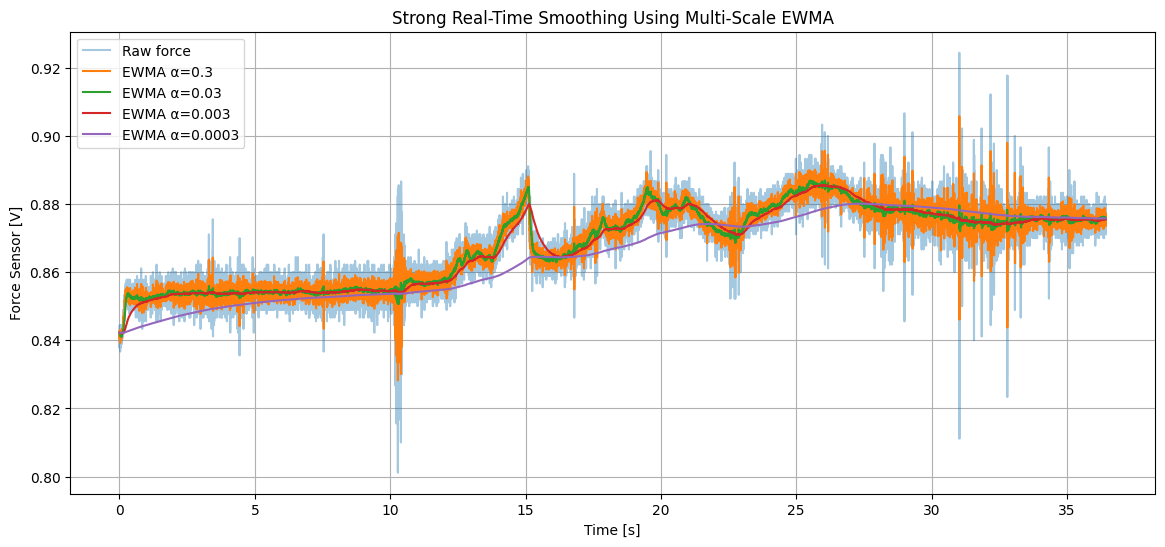

In [15]:
import numpy as np
import matplotlib.pyplot as plt

force = logs[0]["force_sensor_v"].values
time = logs[0]["timestamps"].values

# Choose strong smoothing coefficients
alphas = [0.3, 0.03, 0.003, 0.0003]   # fast → ultra-smooth

# Initialize one EWMA output per alpha
ewmas = [np.zeros_like(force) for _ in alphas]

# Initialize first values
for i in range(len(alphas)):
    ewmas[i][0] = force[0]

# Update EWMA causally
for t in range(1, len(force)):
    x = force[t]
    for i, alpha in enumerate(alphas):
        ewmas[i][t] = alpha * x + (1 - alpha) * ewmas[i][t - 1]

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(time, force, alpha=0.4, label="Raw force")

for i, alpha in enumerate(alphas):
    plt.plot(time, ewmas[i], label=f"EWMA α={alpha}")

plt.title("Strong Real-Time Smoothing Using Multi-Scale EWMA")
plt.xlabel("Time [s]")
plt.ylabel("Force Sensor [V]")
plt.legend()
plt.grid()
plt.show()


# Frequency Analysis

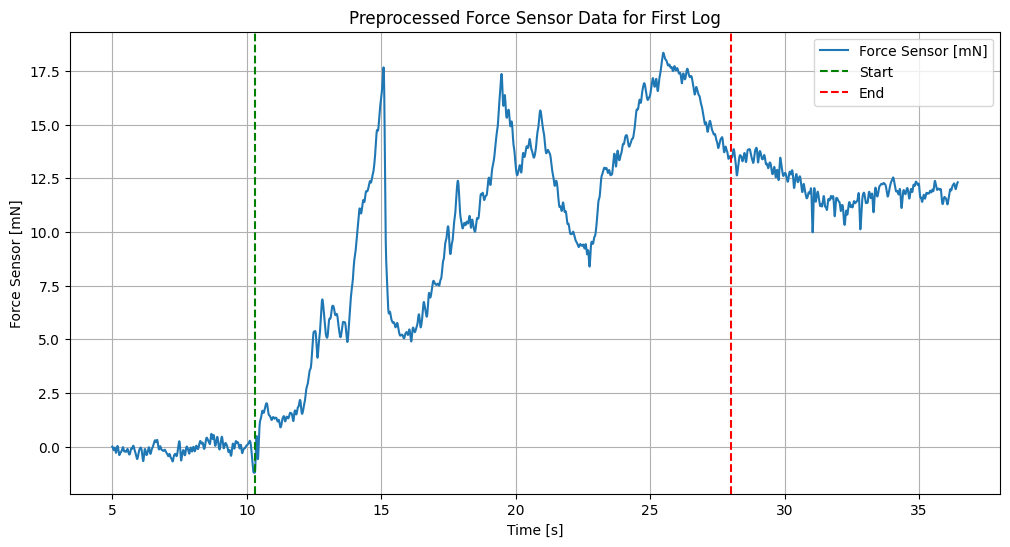

In [16]:
# plot first force curve
for i, df in enumerate(data_fit_plot[:1]):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamps'], df['force_sensor_mN'], label='Force Sensor [mN]')
    # add vertical line at start and end labels 
    plt.axvline(x=labels[i]['Start'].values[0], color='g', linestyle='--', label='Start')
    plt.axvline(x=labels[i]['End'].values[0], color='r', linestyle='--', label='End')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Sensor [mN]')
    plt.title('Preprocessed Force Sensor Data for First Log')
    plt.grid()
    plt.legend()
    plt.show()

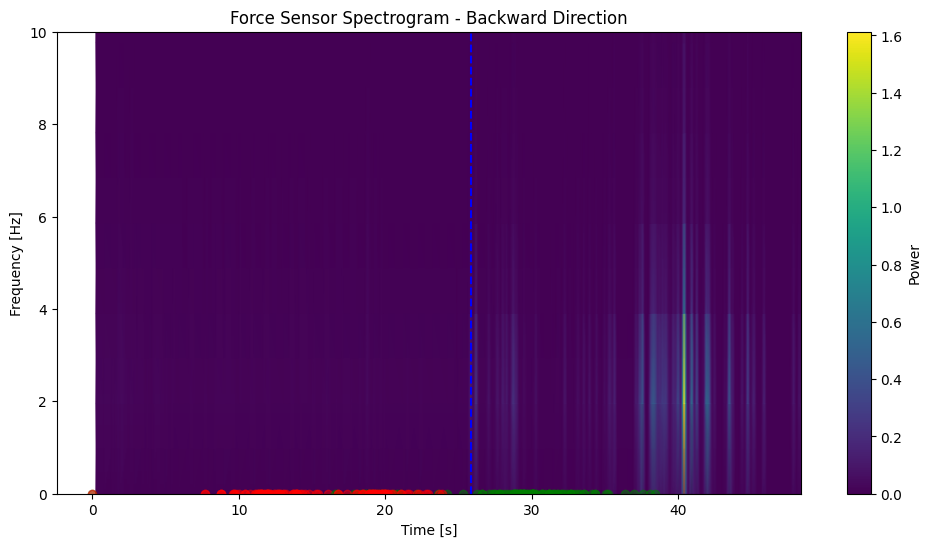

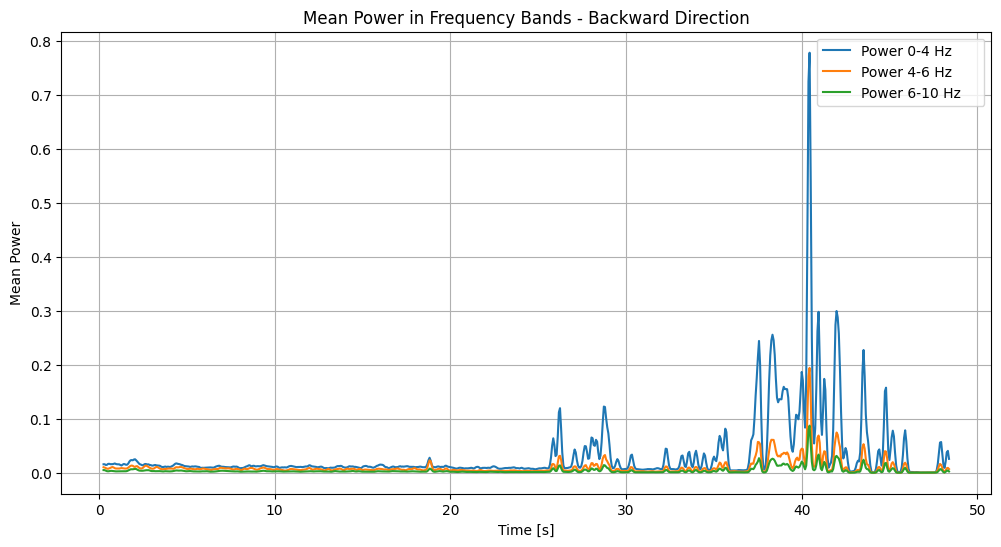

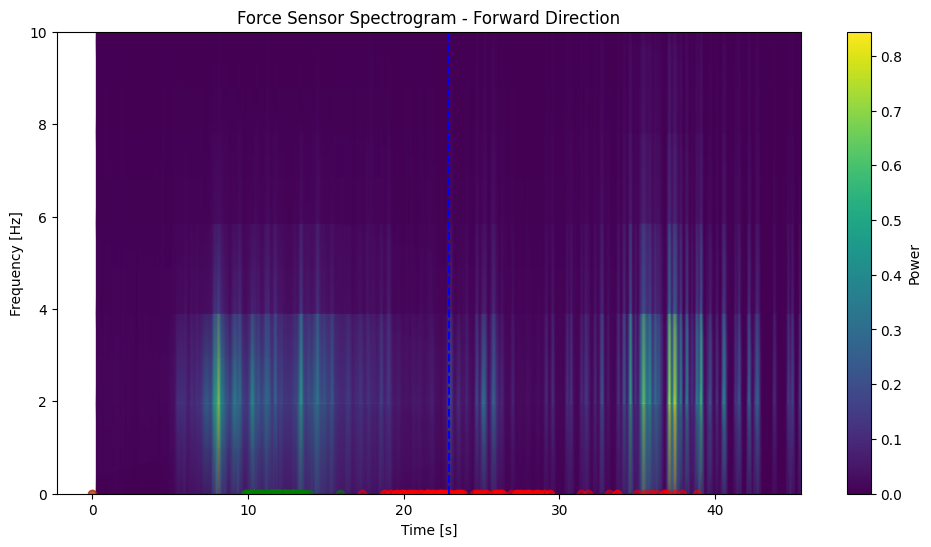

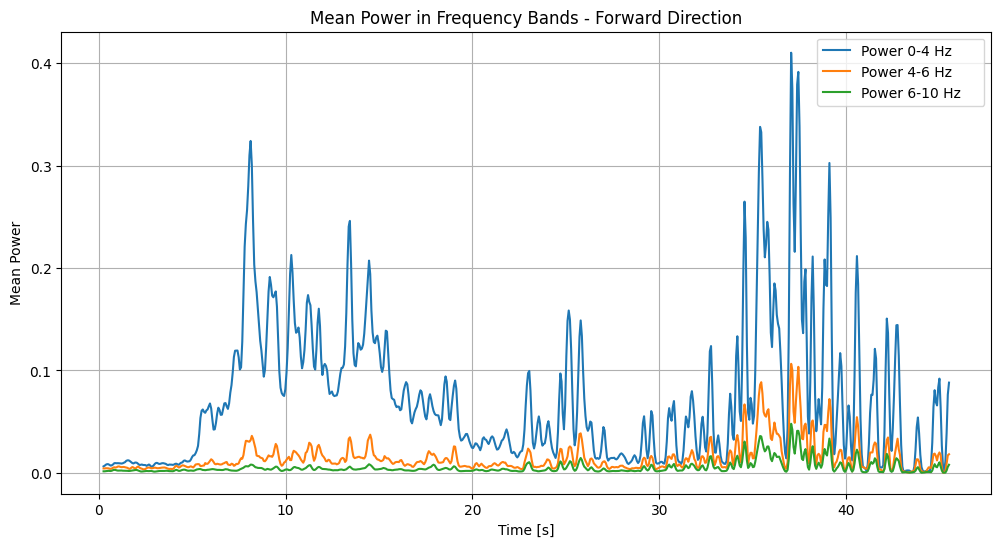

In [53]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram


for direction in ['Backward', 'Forward']:
    Sxx_tot = []
    min_length = min([len(df) for i, df in enumerate(data_fit_plot) if logs_fit.loc[i, 'direction'] == direction])
    max_length = max([len(df) for i, df in enumerate(data_fit_plot) if logs_fit.loc[i, 'direction'] == direction])
    plt.figure(figsize=(12, 6))

    for i, df in enumerate(data_fit_plot):
        if logs_fit.loc[i, 'direction'] != direction:
            continue
        force = df['force_sensor_mN'].values
        # zero pad to max_length
        if len(force) < max_length:
            force = np.pad(force, (0, max_length - len(force)), 'constant')
        fs = 1000  # sampling frequency
        f, t, Sxx = spectrogram(force, fs=fs, window='hann',
                                nperseg=512, noverlap=448,   # ≈ 90% overlap
                                scaling='density')
        Sxx_tot.append(Sxx)

    # compute mean spectrogram
    Sxx_mean = sum(Sxx_tot) / len(Sxx_tot)



    plt.pcolormesh(t, f, Sxx_mean, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Power')
    plt.title(f'Force Sensor Spectrogram - {direction} Direction')
    plt.ylim([0, 10])  # force signals often low-frequency
    # show where we start padding from 
    plt.axvline(x=min_length/1000, color='b', linestyle='--', label='Padding Start')
    for i, df in enumerate(data_fit_plot):
        if logs_fit.loc[i, 'direction'] != direction:
            continue
        plt.scatter(x=labels[i]['Start'].values[0], y=0,color='g', alpha=0.5)
        plt.scatter(x=labels[i]['End'].values[0],y=0, color='r', alpha=0.5) 
    plt.show()

    # plot mean power for band [0,4] Hz [4,6] Hz and [6,10] Hz
    power_0_4 = Sxx_mean[(f >= 0) & (f < 4), :].mean(axis=0)
    power_4_6 = Sxx_mean[(f >= 4) & (f < 6), :].mean(axis=0)
    power_6_10 = Sxx_mean[(f >= 6) & (f <= 10), :].mean(axis=0)
    plt.figure(figsize=(12, 6))
    plt.plot(t, power_0_4, label='Power 0-4 Hz')
    plt.plot(t, power_4_6, label='Power 4-6 Hz')
    plt.plot(t, power_6_10, label='Power 6-10 Hz    ')
    plt.title(f'Mean Power in Frequency Bands - {direction} Direction')
    plt.xlabel('Time [s]')
    plt.ylabel('Mean Power')
    plt.legend()
    plt.grid()
    plt.show()


